 # Understanding $\Omega_\mathrm{gw}$ in Gravitational Wave Experiments

### Mingarelli, Taylor, Sathyaprakesh, Farr
#### email Chiara Mingarelli at chiara.mingarelli@yale.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

import os,sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo

import gwent
import gwent.detector as detector
import gwent.binary as binary

/Users/cmm323/miniconda3/envs/ent15y/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# Useful Functions

In [2]:
time2y = 2*3.154e+7 #scaling for observation time #aLIGO assumes 2 years of data
time5y = 5*3.154e+7
time17y = 17*3.154e+7
time1w = 604800 # seconds in a week

In [3]:
def hc_Om_gw(freq, h_c):
    """
    Set H_0=68 km/s/Mpc
    1 pc = 1.029e+8 light seconds
    """
    pc2sec = 1.029e+8
    metre2sec = 3.3356e-9
    H0_secs = 68*1000*metre2sec/(1e6*pc2sec) # H_0 = 68km/s/Mpc
    num = 2*np.pi**2*freq**2*h_c**2 # quantity in files is really sqrt(S_n(f))
    deno = 3*H0_secs**2
    OmegaGW = num/deno 
    return OmegaGW


def improvement(timespan, fmax, fmin):
    """
    Timespan in years, frequency in hertz
    """
    deltaF = abs(fmax-fmin)
    ans = np.sqrt(timespan*deltaF)
    return ans

def Sn2OmGW(freq, s_of_n):
    """
    Set h=0.68 and use H_0=68 km/s/Mpc
    
    1 pc = 1.029e+8 light seconds
    """
    pc2sec = 1.029e+8
    metre2sec = 3.3356e-9
    H0_secs = 68*1000*metre2sec/(1e6*pc2sec)
    num = 2*np.pi**2*freq**3*s_of_n**2 # quantity in files is really sqrt(S_n(f))
    deno = 3*H0_secs**2
    OmegaGW = 5*num/deno # factor of 5 for LIGO, LISA, ET, and CE. PTAs don't use S_n(f)
    return OmegaGW

def Sn2OmGW_wT(freq, s_of_n, time, dFreq):
    """
    Set H_0=68 km/s/Mpc
    1 pc = 1.029e+8 light seconds
    int_t_improv: integration time improves the detector sensitivity by sqrt(time*dfreq)
    input time in seconds
    """
    pc2sec = 1.029e+8
    metre2sec = 3.3356e-9
    H0_secs = 68*1000*metre2sec/(1e6*pc2sec) # H_0 = 68km/s/Mpc
    num = 2*np.pi**2*freq**3*s_of_n**2 # quantity in files is really sqrt(S_n(f))
    deno = 3*H0_secs**2
    int_t_improv = np.sqrt(time*dFreq)
    OmegaGW = 5*num/deno/int_t_improv # factor of 5 for LIGO, LISA, ET, and CE. PTAs don't use S_n(f)
    return OmegaGW


# Start with Einstein Telescope (ET)

In [4]:
et_curve=np.genfromtxt("ET-0000A-18_ETDSensitivityCurveTxtFile.txt", 
                       names=('freq', 'ET-D-HF', 'ET-D-LF', 'Sum'))

In [5]:
et_curve = Table(et_curve)

# Adding Cosmic Explorer (CE)

In [6]:
ce_curve = np.genfromtxt("ce_wb.dat", names=('freq','CE'))

In [7]:
ce_curve = Table(ce_curve)

In [8]:
ce_w5yrs = Sn2OmGW_wT(ce_curve['freq'], ce_curve['CE'], time5y, 100)

In [9]:
ce_w2yrs = Sn2OmGW_wT(ce_curve['freq'], ce_curve['CE'], time2y, 100)

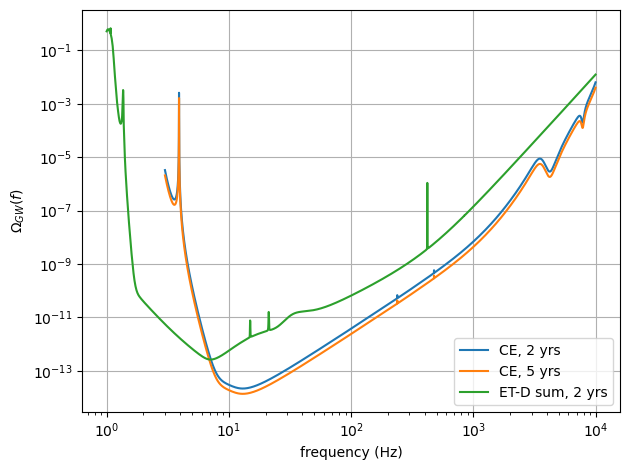

In [10]:
# Compare ET and CE
plt.loglog(ce_curve['freq'], ce_w2yrs, label="CE, 2 yrs")
plt.loglog(ce_curve['freq'], ce_w5yrs, label="CE, 5 yrs")
plt.loglog(et_curve['freq'], Sn2OmGW_wT(et_curve['freq'], et_curve['Sum'], time2y,100)*5, label="ET-D sum, 2 yrs")
plt.grid(True)
plt.ylabel("$\Omega_{GW}(f)$")
plt.xlabel("frequency (Hz)")
plt.legend()
plt.tight_layout()
#plt.savefig("ET_om_gw_2yr_integration.pdf")
plt.show()

# Adding NANOGrav 11 yr data

In [11]:
nano_curve = np.genfromtxt("nanograv18_omega.txt", names=('nanoFreq', 'NANOGrav18'))

In [12]:
nano_curve = Table(nano_curve)

# Add NG 15 data

In [13]:
ng15_Om = np.genfromtxt("log10_omega_gw.txt")
ng15_freqs = np.genfromtxt("log10_freqs.txt")

In [14]:
ng15_Om_list = [ng15_Om[i] for i in range(len(ng15_Om))]

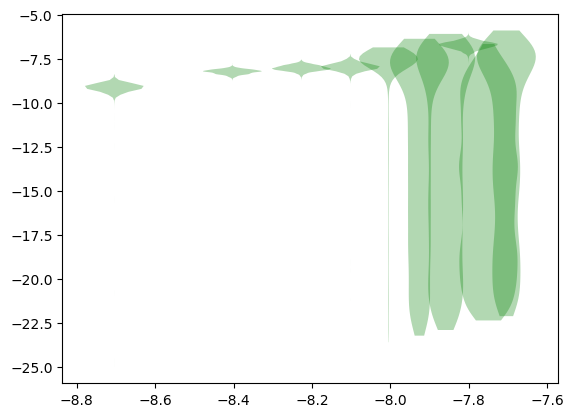

In [15]:
# Make a violin plot

vpt = plt.violinplot(ng15_Om_list[:10], positions=(ng15_freqs[:10]), widths=0.15, showextrema=False)
for pc in vpt['bodies']:
    pc.set_facecolor('g')
    pc.set_alpha(0.3)

#plt.savefig("testOmgw.pdf")

# Add Advanced LIGO at Design Sensitivity

In [16]:
aligo_dat = np.genfromtxt("aLIGO_design.dat", delimiter='', skip_header=1, names=("freq", "omega"))

In [17]:
aligo_dat = Table(aligo_dat)

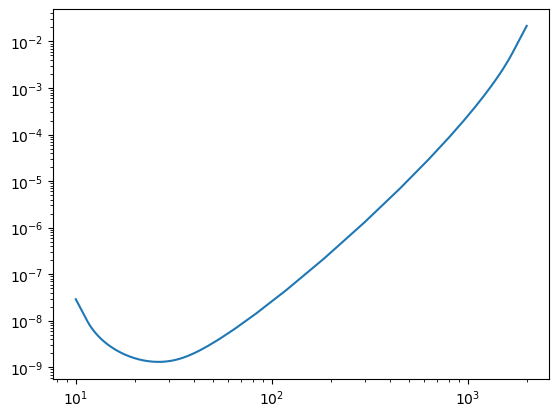

In [18]:
plt.loglog(aligo_dat['freq'], aligo_dat['omega'])

# Add LISA

In [19]:
lisa_dat = np.genfromtxt("PICurve_LISA.dat", delimiter='', skip_header=1, names=("freq", "omega"))

In [20]:
lisa_dat = Table(lisa_dat)

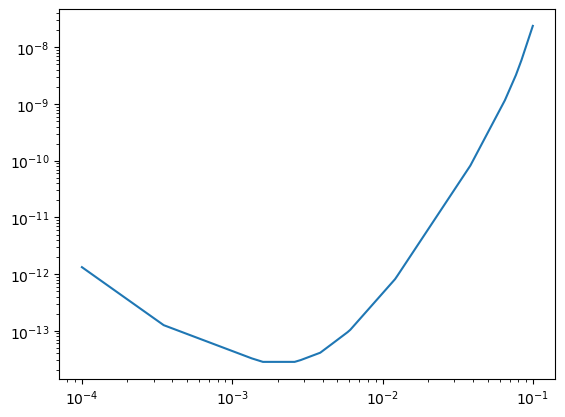

In [21]:
plt.loglog(lisa_dat['freq'], lisa_dat['omega'])

In [22]:
n = 150 # remove the first n points for ET & CE so that the high frequency cutoff does not dominate the figure

# SKA Detector

In [30]:

sigma_SKA = 50*u.ns.to('s')*u.s #sigma_rms timing residuals in nanoseconds to seconds
T_SKA = 10*u.yr #Observing time in years
N_p_SKA = 200 #Number of pulsars
cadence_SKA = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in [number/yr]


In [31]:
SKA_WN = detector.PTA('SKA, WN Only', N_p_SKA, T_obs=T_SKA, cadence=cadence_SKA, sigma=sigma_SKA)

In [32]:
#SKA_WN = detector.PTA('SKA, WN Only',T_SKA,N_p_SKA,sigma_SKA,cadence_SKA)

In [23]:
#Convert to log scale to faciliate violin plots later

#for LIGO data
logFreq_aligo = [np.log10(x) for x in aligo_dat['freq']]
logOm_aligo = [np.log10(x) for x in aligo_dat['omega']]

#for LISA data
logFreq_LISA = [np.log10(x) for x in lisa_dat['freq']] 
logOm_LISA = [np.log10(x) for x in lisa_dat['omega']] 

#for ET
logFreq_ET = [np.log10(x) for x in et_curve['freq'][n:]]
logOm_ET = [np.log10(x) for x in et_curve['Sum'][n:]]

#for CE
logFreq_CE = [np.log10(x) for x in ce_curve['freq'][n:]]
logOm_CE = [np.log10(x) for x in  ce_curve['CE'][n:]]



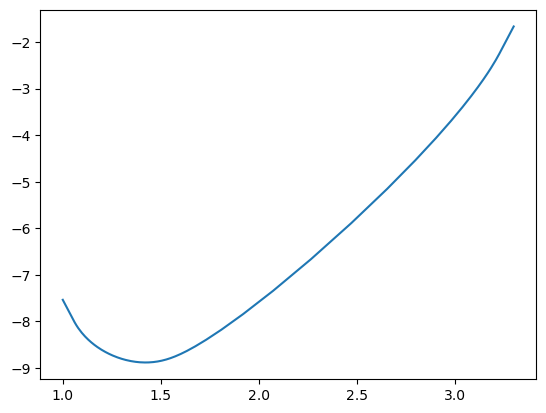

In [24]:
plt.plot(logFreq_aligo, logOm_aligo)

In [25]:
# axis gymnastics for plotting below.
ET_y_ax = Sn2OmGW_wT(et_curve['freq'][n:], et_curve['Sum'][n:], time2y, 100)
logOm_ET_yaxis = [np.log10(x) for x in ET_y_ax]
CE_y_ax = Sn2OmGW_wT(ce_curve['freq'][n:], ce_curve['CE'][n:], time2y, 100)
logOm_CE_yaxis = [np.log10(x) for x in CE_y_ax]

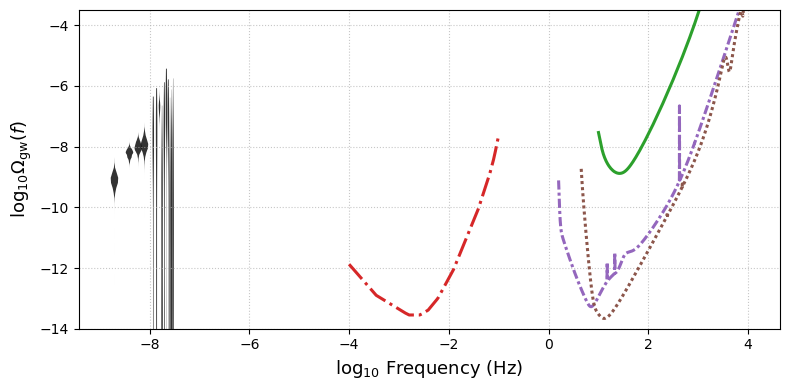

In [38]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
NGcut = 8

#plt.loglog(SKA_WN.fT, hc_Om_gw(SKA_WN.fT, SKA_WN.h_n_f), label = "SKA", ls="--", lw=1)
#plt.loglog(nano_curve['nanoFreq'], nano_curve['NANOGrav 15']/(.68)**2, label='NANOGrav 2023')

vpt = plt.violinplot(ng15_Om_list[:4], positions=(ng15_freqs[:4]), widths=0.15, showextrema=False)
for pc in vpt['bodies']:
    pc.set_facecolor('black')
    pc.set_alpha(0.8)
    #pc.set_edgecolor('black') 

vpt2 = plt.violinplot(ng15_Om_list[5:15], positions=(ng15_freqs[5:15]), widths=0.03, showextrema=False)
for pc in vpt2['bodies']:
    pc.set_facecolor('black')
    pc.set_alpha(0.8)
    #pc.set_edgecolor('black') 

#plt.loglog(nano_curve['nanoFreq'], nano_curve['NANOGrav18']/(.68)**2/improvement(time17y, \
#                                                    1/(2*time1w), 1/(time17y)) , ls=":", label="NANOGrav 2036*")
#plt.hlines(nano_curve['nanoFreq'], 1.0/17/365.25/86400.0, nano_curve['nanoFreq'][0], color='C1')

plt.plot(logFreq_aligo, logOm_aligo, label= "aLIGO", linewidth=2.2)
plt.plot(logFreq_LISA, logOm_LISA, label= "LISA", ls = '-.', linewidth=2.2)
plt.plot(logFreq_ET, logOm_ET_yaxis, label="ET-D", ls = (0, (3, 1, 1, 1)), linewidth=2.2)
plt.plot(logFreq_CE, logOm_CE_yaxis, label="Cosmic Explorer", ls = (0, (1, 1)), linewidth=2.2)


#plt.annotate('NG11',(freq_yr, nanoOmega11))
ax.grid(which='major', axis='both', alpha=0.7, linestyle=":")

plt.ylabel("$\log_{10}\Omega_\mathrm{gw}(f)$", fontsize=13)
plt.xlabel("$\log_{10}$ Frequency (Hz)", fontsize=13)
#plt.legend(loc=9)
plt.tight_layout()
plt.ylim(-14,-3.5)
plt.savefig("Omega_gw_fig3.pdf")
plt.show()